# Ensemble Classification

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay, classification_report, make_scorer, fbeta_score, RocCurveDisplay, DetCurveDisplay

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [72]:
data_full = pd.read_csv("../data/processed/full_all_day_ahead.csv")
cols_1da = [c for c in data_full.columns if c.endswith("_1") or c == "Abnormal"]
data_1da = data_full[cols_1da]
data_1da = data_1da.dropna()
data_1da_reduced = data_1da.drop(columns="RR_1")
X = data_1da_reduced.drop(columns="Abnormal")
y = data_1da_reduced.Abnormal

np.random.seed(500)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)
class_bal = pd.concat([pd.Series(y_test).value_counts(), pd.Series(y_train).value_counts()], axis=1)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

## Random Forest

In [27]:
pipe_rf = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", RandomForestClassifier(n_jobs=-1))
])

rf_grid = {
  "clf__n_estimators": [50, 100, 250],
  "clf__min_samples_split": [2, 3, 4],
  "clf__max_depth": [None, 2, 5, 10]
}

kf = StratifiedKFold(n_splits=10)
search = GridSearchCV(pipe_rf, rf_grid, cv=kf, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
mod_rf = search.best_estimator_

Best params: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}


## XGBoost

In [81]:
pipe_xgb = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", XGBClassifier(n_jobs=-1, eval_metric=make_scorer(fbeta_score, beta=2)))
])

xgb_grid = {
  "clf__max_depth": [x for x in range(11)],
  "clf__max_delta_step": [x for x in range(5)],
  "clf__learning_rate": [0.01, 0.1, 0.2, 0.3],
  "clf__n_estimators": [50, 75, 100]
}

kf = StratifiedKFold(n_splits=10)
search = RandomizedSearchCV(pipe_xgb, xgb_grid, n_iter=50, cv=kf, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
mod_xgb = search.best_estimator_

Best params: {'clf__n_estimators': 100, 'clf__max_depth': 0, 'clf__max_delta_step': 3, 'clf__learning_rate': 0.3}


## Comparison

### Train ROC

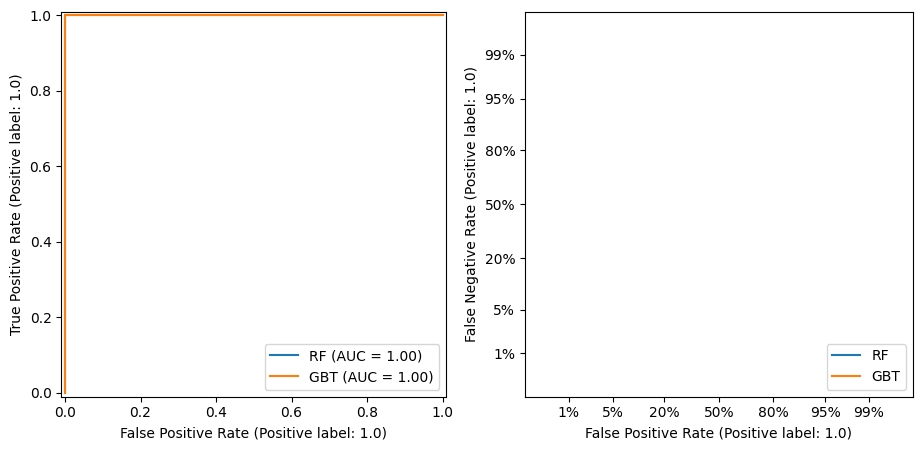

In [29]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

models = {
  "RF": mod_rf,
  "GBT": mod_gbt,
}
for name, mod in models.items():
  RocCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_det, name=name)

### Test ROC

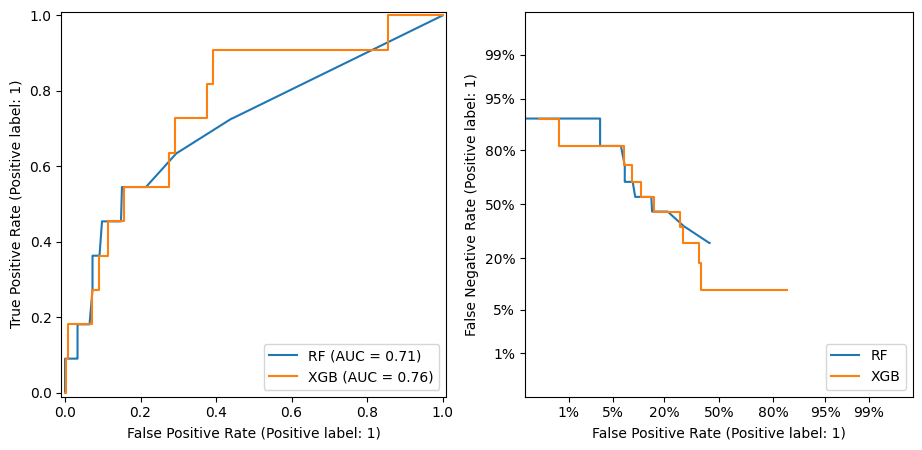

In [82]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

models = {
  "RF": mod_rf,
  "XGB": mod_xgb,
}
for name, mod in models.items():
  RocCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_det, name=name)